In [1]:
!pip install wikipedia matplotlib==3.0.3 seaborn -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 8.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.18.0 requires matplotlib>=3.5, but you have matplotlib 3.0.3 which is incompatible.
bigframes 1.17.0 requires matplotlib>=3.7.1, but you have matplotlib 3.0.3 which is incompatible.
mizani 0.9.3 requires matplotlib>=3.5.0, but you have matplotlib 3.0.3 which is incompatible.
plotnine 0.12.4 requires matplotlib>=3.6.0, but you have matplotlib 3.0.3 which is incompatible.


# Вспоминаем, что было на прошлом семинаре:
1. Какие этапы работы с данными существуют?
2. Какие могут быть особенности в токенизации?
3. Какие бывают метрики?
4. Какой итоговый пайплайн для создания спеллчеккера?

# Семинар 2. Препроцессинг. Определение языка

In [44]:
from collections import Counter
import wikipedia
import re

import nltk
nltk.download("punkt")

import random
random.seed(0)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Данные
Независимо от способа определения языка, нам нужны данные. Для этого выкачаем для нужных нам языков страницы с Википедии.

In [3]:
TEST_LANGS = ('es', 'it', 'kk', 'ru', 'uk', 'be')

In [4]:
def get_texts_for_lang(lang, n=10):
    wiki_content = []
    wikipedia.set_lang(lang)
    pages = wikipedia.random(n+10)
    page_idx = 0
    while len(wiki_content) != n and len(pages) != page_idx:
        try:
            page_name = pages[page_idx]
            page = wikipedia.page(page_name)
            wiki_content.append(f"{page.title}\n{page.content.replace('=', '')}")  # = используется в названиях глав
        except wikipedia.exceptions.WikipediaException:
            print("Skip %s" % page_name)
        page_idx += 1
    return wiki_content

In [5]:
wiki_texts = {}
for lang in TEST_LANGS:
    wiki_texts[lang] = get_texts_for_lang(lang, 30)
    print(lang, len(wiki_texts[lang]))

es 30


/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Skip Viva Voce
Skip Campobellesi
Skip Diocesi di Macon
it 30
kk 30
Skip Купер, Дерек
Skip Дейд (округ, Джорджия)
ru 30
Skip Садово (значення)
uk 30
Skip Бруханаў
Skip Грыфін
Skip Пятроўцы
be 30


## 2. Методы определения языка

### Идея 1. Определим по частотным словам.

Попробуем выделить частотные слова для каждого языка и по ним определять язык. Для начала давайте создадим счетчик с самыми частотными словами. Не забудьте:
- токенизировать любым удобным вам образом
- избавиться от цифр и прочего мусора
- вывод должен быть в виде словаря из ста самых частых слов

In [6]:
from string import punctuation

def collect_freqlist(wiki_pages, max_len=100):
    freqlist = Counter()
    for text in wiki_pages:
        for word in nltk.word_tokenize(text.lower()):
            word = re.sub('\d', '', word)
            if word.isalpha():
                freqlist[word] += 1
    return dict(freqlist.most_common(max_len))

In [ ]:
collect_freqlist(wiki_texts['ru'])

__Вопросы:__
- почему не стоит брать совсем редкие слова? (встретились 2-3 раза)
- почему стоит параметр размера словаря - 100? Как можно определить оптимальный?
- в данном случае мы не выкидываем формы одного слова. Какие могут быть минусы и плюсы подобного подхода?

In [8]:
freq_lists = {}
for lang in TEST_LANGS:
    freq_lists[lang] = collect_freqlist(wiki_texts[lang])

In [9]:
def simple_lang_detect(freq_lists, text):
    counts = Counter()
    for lang, freq_list in freq_lists.items():
        freq_list = Counter(freq_list)
        for word in nltk.word_tokenize(text):
            word = re.sub('\d', '', word)
            counts[lang] += int(freq_list[word] > 0)
    return counts.most_common()

In [10]:
test_texts = get_texts_for_lang('it', n = 1)[0]
print(test_texts[:1000])

Tratta di esseri umani
La tratta di esseri umani o tratta di persone è un'attività criminale finalizzata alla cattura, il sequestro o il reclutamento, nonché il trasporto, il trasferimento, l'alloggio o l'accoglienza di una o più persone, usando mezzi illeciti e ai fini dello sfruttamento delle stesse. Nel Protocollo delle Nazioni Unite contro la tratta delle persone viene definita come: A differenza del traffico di migranti, la tratta di persone avviene senza il consenso degli individui oggetto della stessa ed è finalizzata non al trasporto in un altro Stato, bensì al loro sfruttamento.
Nonostante la notevole quantità di provvedimenti legislativi, resta l'inadeguatezza delle organizzazioni internazionali a delineare almeno per grandi numeri le proporzioni del fenomeno. Ad oggi non si dispone di dati precisi ed univoci sul mercato nero degli esseri umani destinati allo sfruttamento sessuale e non, poiché le stime eseguite dalle Organizzazioni non governative e dalle Nazioni Unite non o

In [11]:
simple_lang_detect(freq_lists, test_texts)

[('it', 1591), ('es', 541), ('kk', 0), ('ru', 0), ('uk', 0), ('be', 0)]

#### Accuracy нашего метода

Создадим отдельную тестовую выборку, на основе которой будем сравнивать работу методов.

In [12]:
wiki_texts_test = {}
test_size = 10
for lang in TEST_LANGS:
    wiki_texts_test[lang] = get_texts_for_lang(lang, test_size)
    print(lang, len(wiki_texts_test[lang]))

es 10
Skip Hrbov
it 10
kk 10
ru 10
Skip Бінь
uk 10
be 10


In [13]:
from sklearn.metrics import accuracy_score

def test_simple_lang_detect(freq_lists, wiki_texts_test):
    results = []  # сюда будем писать результаты
    gold = []     # сюда будем писать исходный язык
    mistakes = []
    for lang in TEST_LANGS:
        lang_texts = wiki_texts_test[lang]
        for text in lang_texts:
            predicted_lang = simple_lang_detect(freq_lists, text)
            results.append(predicted_lang[0][0])
            gold.append(lang)

            if predicted_lang[0][0] != lang:
                mistakes.append([text.split('\n')[0], lang, predicted_lang])
    print("RESULTS:")
    print(f"{len(TEST_LANGS)} languages")
    print(f"Test size: {len(lang_texts)} texts per language")
    print(f"Accuracy: {accuracy_score(results, gold):.4f}")
    return mistakes

In [14]:
# проверка
mistakes = test_simple_lang_detect(freq_lists, wiki_texts_test)

RESULTS:
6 languages
Test size: 10 texts per language
Accuracy: 0.9667


In [15]:
mistakes

[['Футболдан Өзбекстан чемпионаты 1998',
  'kk',
  [('es', 0), ('it', 0), ('kk', 0), ('ru', 0), ('uk', 0), ('be', 0)]],
 ['Ілія II Александрійський',
  'uk',
  [('it', 12), ('uk', 5), ('be', 2), ('es', 1), ('ru', 1), ('kk', 0)]]]

__Как можно доработать этот подход?__

Считать не количество слов каждого языка, а некоторый коэффициент, основанный на частоте встречаемости слова в языке. Т.е. если слово встречается в этом языке часто, то выше вероятность, что текст написан на нём. (м.б. что-то похожее на tf-idf)

### Идея 2. Префиксы-суффиксы


Что если мы хотим учитывать морфологию при анализе? Тут сразу появляется проблема: пока мы не знаем, какой язык перед нами, мы не знаем, как в нём работает морфология.

In [16]:
import nltk
ps = nltk.stem.PorterStemmer()
ps.stem('машины')

'машины'

Попробуем вариант "в лоб": соберём список частотных префиксов и суффиксов. Для этого возьмём все те же тексты, и для каждого слова будем сохранять все его преффиксы и суффиксы. Например, для слова *машина* мы сохраним следующий набор: *машина*, *машин*, *маши*, *маш*, *ма*, *м*, *ашина*, *шина*, *ина*, *на*, *а*

In [17]:
def collect_pref_suff_freqlist(wiki_pages, max_len=200):
    freqlist = Counter()
    for text in wiki_pages:
        for word in nltk.word_tokenize(text):
            word = re.sub('\d', '', word)
            if word.isalpha():
                for i in range(len(word)+ 1):
                    if len(word[i:]) >= 1:
                        freqlist[word[i:]] += 1
                    if len(word[:i]) >= 1:
                        freqlist[word[:i]] += 1
    return dict(freqlist.most_common(max_len))

In [18]:
# collect_pref_suff_freqlist(wiki_texts['ru'])

In [19]:
freq_pref_suff_lists = {}
for lang in TEST_LANGS:
    freq_pref_suff_lists[lang] = collect_pref_suff_freqlist(wiki_texts[lang])

In [20]:
def new_simple_lang_detect(freq_lists, text):
    counts = Counter()
    for lang, freq_list in freq_lists.items():
        freq_list = Counter(freq_list)
        for word in nltk.word_tokenize(text):
           word = re.sub('\d', '', word)
           for i in range(len(word)+ 1):
                if len(word[i:]) > 1:
                    counts[lang] += int(freq_list[word[i:]] > 0)
                if len(word[:i]) > 1:
                    counts[lang] += int(freq_list[word[:i]] > 0)
    return counts.most_common()

In [21]:
simple_lang_detect(freq_pref_suff_lists, test_texts)

[('it', 1496), ('es', 1018), ('uk', 151), ('ru', 120), ('kk', 0), ('be', 0)]

In [22]:
mistakes = test_simple_lang_detect(freq_pref_suff_lists, wiki_texts_test)

RESULTS:
6 languages
Test size: 10 texts per language
Accuracy: 0.9500


In [23]:
mistakes

[['Футболдан Өзбекстан чемпионаты 1998',
  'kk',
  [('es', 0), ('it', 0), ('kk', 0), ('ru', 0), ('uk', 0), ('be', 0)]],
 ['Триплатинасвинец',
  'ru',
  [('es', 14), ('it', 14), ('ru', 4), ('uk', 4), ('kk', 2), ('be', 1)]],
 ['Ілія II Александрійський',
  'uk',
  [('it', 11), ('uk', 6), ('ru', 5), ('es', 4), ('kk', 4), ('be', 4)]]]

- А какие проблемы могут возникнуть тут?

### Идея 3. Машинное обучение

Будем говорить о **supervised** методах (обучение с учителем):

* У нас есть пары `(признаки, класс)`
* Классификатор обучается на них — подбирает подходящую функцию отображения признаков в множество классов
* После этого можно применять полученную модель для предсказаний на новых данных

Признаки могут быть разные:
* средняя/минимальная/максимальная длина слова
* векторизированные слова/символы/топ-n слов
* векторизированные предложения/тексты

Для определения языка часто используют не слова, а последовательности символов (символьные n-граммы / character ngrams). Например, 3-граммы:
```
сим, имв, мво, вол, оло, лов
```

Из обучающих данных соберем словарь символьных n-грамм $V$.
Тогда каждый текст сможем представить в виде вектора длины $|V|$, где каждый признак показывает, присутствует ли соответствующая n-грамма в тексте.

Будем использовать $tf \cdot idf$, чтобы учитывалась важность символов для строки:

$tf \cdot idf (n, d) = \frac{count(n_d)}{\sum_{w \in d}count(w)} \cdot log\frac{|D|}{|\{d \in D | n \in d\}|}$

где $n$ - n-грамма, $d$ - документ, а $D$ - весь корпус (на данном языке)

#### Векторизация

In [24]:
from sklearn import feature_extraction

vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1, 5), analyzer='char')
vectorizer.fit(wiki_texts['ru'])
# for item in vectorizer.get_feature_names_out()[:100]:
#    print(item)

TfidfVectorizer(analyzer='char', ngram_range=(1, 5))

In [43]:
print(vectorizer.transform(wiki_texts['ru'])[0].shape)

(1, 81245)


#### Пайплайн обучения

In [26]:
from sklearn import pipeline
from sklearn import naive_bayes
import numpy as np

#%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

1. Строим пайплайн классификатора

In [27]:
clf = pipeline.Pipeline([
    ('vctr', feature_extraction.text.TfidfVectorizer(ngram_range=(1, 2), analyzer='char')), #на какие фичи смотрим
    ('clf', naive_bayes.MultinomialNB()) #параметр
])

2. Делаем обучающую и тестовую выборки

In [28]:
all_texts = []
lang_indices = []
for lang in wiki_texts:
    all_texts.extend(wiki_texts[lang])
    lang_indices.extend([lang]*len(wiki_texts[lang])) # массив с названиями языками

test_texts = []
test_lang_indices = []
for lang in wiki_texts:
    test_texts.extend(wiki_texts_test[lang])
    test_lang_indices.extend([lang]*len(wiki_texts_test[lang])) # массив с названиями языками

3. Обучаем классификатор

Так как мы сделали тестовую выборку, которой сравниваем результаты по разным методам, пусть будет три выборки: обучающая, валидационная и тестовая.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_val, y_train, y_val = train_test_split(all_texts,
                                                    lang_indices,
                                                    test_size=0.2,
                                                    random_state=0)
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_val)
cm = metrics.confusion_matrix(y_val, y_predicted)

In [30]:
print(y_predicted)
print(y_val)

['ru' 'es' 'uk' 'be' 'uk' 'kk' 'it' 'be' 'be' 'ru' 'it' 'be' 'be' 'es'
 'es' 'ru' 'be' 'uk' 'it' 'ru' 'uk' 'kk' 'kk' 'it' 'uk' 'be' 'ru' 'be'
 'be' 'kk' 'it' 'es' 'ru' 'uk' 'kk' 'it']
['ru', 'es', 'uk', 'be', 'uk', 'kk', 'it', 'be', 'be', 'ru', 'it', 'be', 'be', 'es', 'es', 'ru', 'be', 'uk', 'it', 'ru', 'uk', 'kk', 'kk', 'es', 'uk', 'be', 'ru', 'be', 'be', 'kk', 'it', 'es', 'ru', 'uk', 'kk', 'es']


In [31]:
y_test_predicted = clf.predict(test_texts)
cm_test = metrics.confusion_matrix(test_lang_indices, y_test_predicted)

In [32]:
# Нарисуем confusion matrix и оценим качество
def test_classify(y_test, y_predicted, label_names):
    cm = metrics.confusion_matrix(y_test, y_predicted)

    plt.figure(figsize=(10, 10))
    plt.ylim(10.5, -0.5)
    sns.heatmap(cm, annot=True,  fmt='', xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')

    print(metrics.classification_report(y_test, y_predicted,
                                        target_names=label_names))

              precision    recall  f1-score   support

          be       1.00      1.00      1.00        10
          es       1.00      0.70      0.82        10
          it       0.67      1.00      0.80        10
          kk       1.00      1.00      1.00        10
          ru       1.00      0.90      0.95        10
          uk       1.00      0.90      0.95        10

    accuracy                           0.92        60
   macro avg       0.94      0.92      0.92        60
weighted avg       0.94      0.92      0.92        60



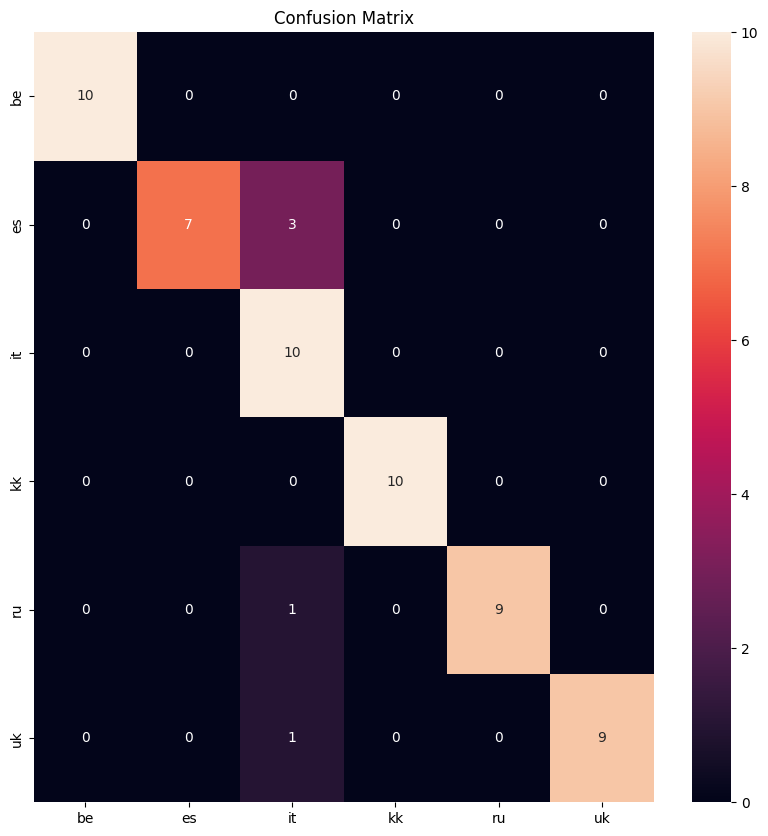

In [33]:
test_classify(test_lang_indices, y_test_predicted, clf.classes_)

              precision    recall  f1-score   support

          be       1.00      1.00      1.00         9
          es       1.00      0.67      0.80         6
          it       0.67      1.00      0.80         4
          kk       1.00      1.00      1.00         5
          ru       1.00      1.00      1.00         6
          uk       1.00      1.00      1.00         6

    accuracy                           0.94        36
   macro avg       0.94      0.94      0.93        36
weighted avg       0.96      0.94      0.94        36



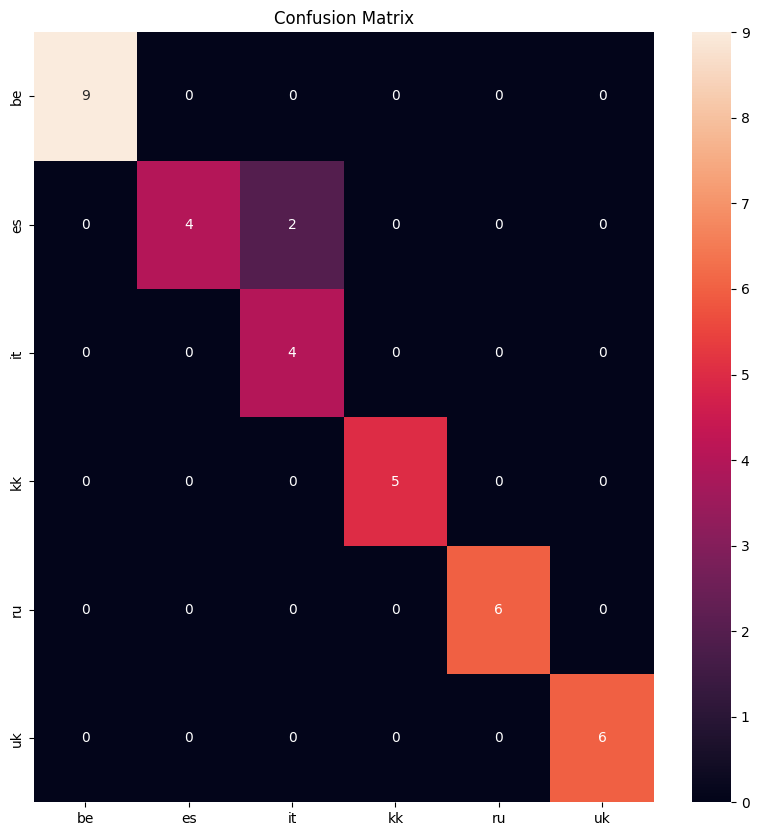

In [34]:
test_classify(y_val, y_predicted, clf.classes_)

              precision    recall  f1-score   support

          be       1.00      1.00      1.00         9
          es       1.00      0.83      0.91         6
          it       0.80      1.00      0.89         4
          kk       1.00      1.00      1.00         5
          ru       1.00      1.00      1.00         6
          uk       1.00      1.00      1.00         6

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.98      0.97      0.97        36



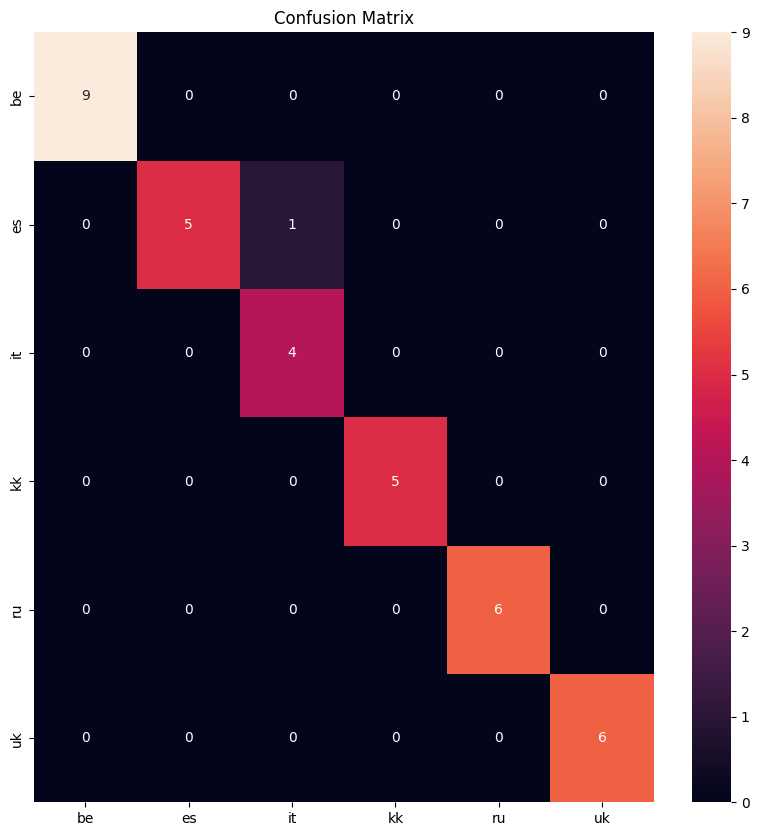

In [45]:
# Проверим на случайных отрывках из тестовых текстов
import random

small_texts = []
for text in X_val:
    begin = random.randint(0, len(text) - 50)
    small_texts.append(text[begin:begin+50])
y_predicted_small = clf.predict(small_texts)
test_classify(y_val, y_predicted_small, clf.classes_)

## Задание

[Здесь](https://disk.yandex.ru/d/O0r3gHiUwTRmmg) лежит текст Анны Карениной на английском. Ваше задание -- взять текст и один из рассмотренных в ходе семинара методов определения языка и извлечь несколько предложений на французском из текста.